In [2]:
# At the very end of the script, I append the pymolrc file used to draw the x, y, z axes in PyMOL.

In [3]:
import biotite.structure as struc
import biotite.structure.io as strucio
from biotite.structure.io.pdb import PDBFile
import numpy as np
from collections import defaultdict

# First I load the pdb structure to pymol and find they have altloc, then I roughly brouse which ligand I want to load
# load_structure(file_path, template=None, **kwargs) where the kwargs are used to pass argument to get_structure() or read()
# biotite.structure.io.pdb.get_structure(pdb_file, model=None, altloc='first', extra_fields=[], include_bonds=False)
# extra_fields: list of str, optional, These are valid values: 'atom_id', 'b_factor', 'occupancy' and 'charge'.
atom_array = strucio.load_structure(file_path='/home/eva/20251207_python_playground/3U8K.pdb', model=1, altloc='first')

# 1. Filter solvent
print(f"atom_array without filter solvent: {atom_array.shape}")
solvent = atom_array[struc.filter_solvent(atom_array)]
print(f"solvent: {solvent.shape}")

# Get the res_name and number from the solvent
vals, counts = np.unique(solvent.res_name ,return_counts=True)
print(f"Solvent name {vals}, Number {counts}")

# 2. Check the non-protein component
removed_solvent = atom_array[~struc.filter_solvent(atom_array)]
print(f"remove solvent HOH: {removed_solvent.shape}")

protein_only = removed_solvent[struc.filter_amino_acids(removed_solvent)]
print(f"protein only: {protein_only.shape}")

# Check the component that is not protein and not solvent
not_protein_not_solvent = removed_solvent[~struc.filter_amino_acids(removed_solvent)]
vals, counts = np.unique(not_protein_not_solvent.res_name, return_counts=True)
other_molecule = list(zip(vals, counts))
final_dict = {str(content[0]):int(content[1]) for content in other_molecule}
print(f"Other component that is not HOH (solvent) or protein is: {final_dict}")

# Keep both protein and NAG small molecule
is_nag = removed_solvent.res_name == 'NAG'
protein_with_NAG = removed_solvent[struc.filter_amino_acids(removed_solvent) | is_nag]
print(f"protein with NAG shape: {protein_with_NAG.shape}")

# Output into pdb file to double check
pdb = PDBFile()
pdb.set_structure(protein_with_NAG)
pdb.write("protein_with_NAG.pdb")



atom_array without filter solvent: (34111,)
solvent: (1381,)
Solvent name ['HOH'], Number [1381]
remove solvent HOH: (32730,)
protein only: (32318,)
Other component that is not HOH (solvent) or protein is: {'09P': 320, 'NAG': 42, 'SO4': 50}
protein with NAG shape: (32360,)


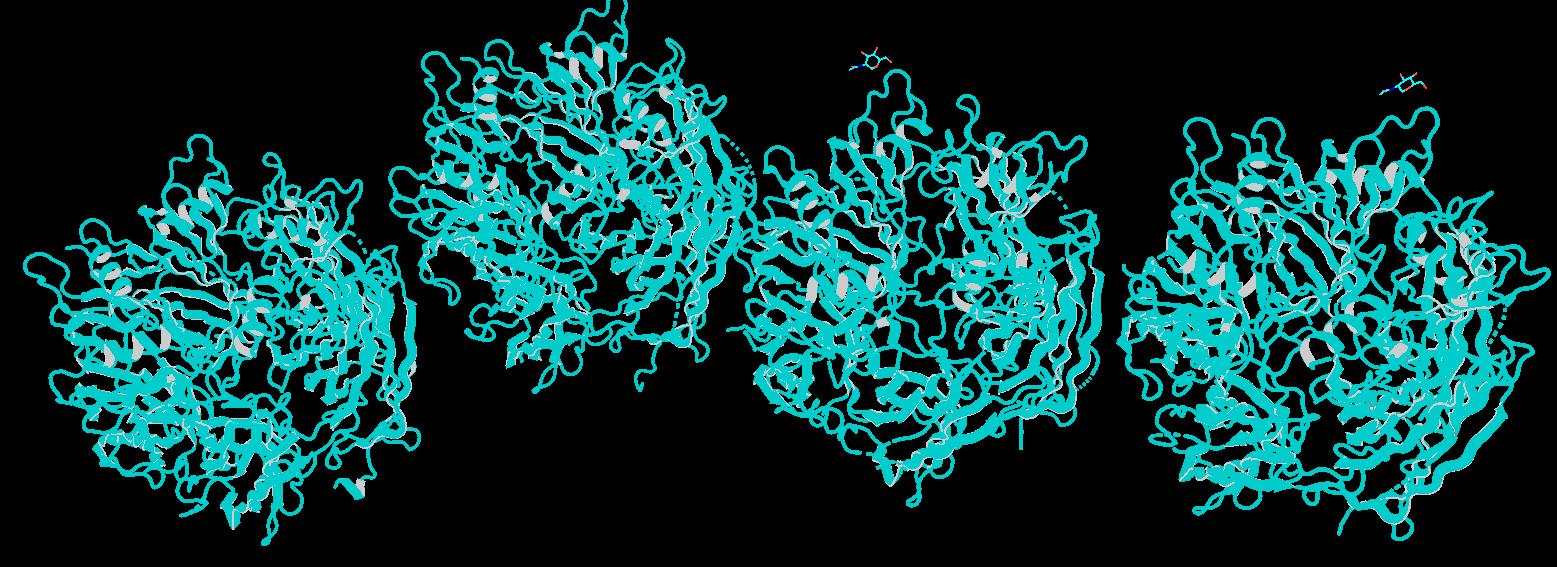

In [4]:
# now we only look at one complex
one_chain = protein_only[np.isin(protein_only.chain_id, ['A'])]
resi_id, count = np.unique_counts(one_chain.res_id)

# check continuity of resi_id from resi_id array
# print(resi_id)
# print(count)
# manually check if there is gap in resi id
gaps = np.where(np.diff(resi_id) != 1)[0]
print("Gaps found at indices:", gaps)



Gaps found at indices: []


In [5]:
check_res_id_continuity = struc.check_res_id_continuity(one_chain) 
print("Check if the residue IDs are incremented by more than 1 or decremented, from one atom to the next one.")
print(check_res_id_continuity)
print(check_res_id_continuity.shape)

check_backbone_continuity = struc.check_backbone_continuity(one_chain) 
print("Check if the (peptide or phosphate) backbone atoms have non-reasonable distance to the next atom.")
print(check_backbone_continuity)
print(check_backbone_continuity.shape)

check_duplicate_atoms = struc.check_duplicate_atoms(one_chain) 
print("Check if a structure contains duplicate atoms")
print(check_duplicate_atoms)
print(check_duplicate_atoms.shape)


Check if the residue IDs are incremented by more than 1 or decremented, from one atom to the next one.
[]
(0,)
Check if the (peptide or phosphate) backbone atoms have non-reasonable distance to the next atom.
[]
(0,)
Check if a structure contains duplicate atoms
[]
(0,)


In [6]:
# Rotation (will expand more in the following sections)
one_complex = protein_only[np.isin(protein_only.chain_id, ['A', 'B', 'C', 'D', 'E'])]
one_complex_residue_11_chain_A = one_complex[(one_complex.res_id == 11) & (one_complex.chain_id == 'A')]
one_complex_new_position = struc.rotate(one_complex, angles=(0, 0, 0.5*np.pi))
one_complex_rotate_residue_11_chain_A = one_complex_new_position[(one_complex_new_position.res_id == 11) & (one_complex_new_position.chain_id == 'A')]

# compare the coordinate
atom_before = one_complex_residue_11_chain_A[one_complex_residue_11_chain_A.atom_name == 'CA'].coord
atom_after = one_complex_rotate_residue_11_chain_A[one_complex_rotate_residue_11_chain_A.atom_name == 'CA'].coord

print(atom_before, atom_after)

[[65.316 94.109 -7.242]] [[-94.109  65.316  -7.242]]


In [7]:
# We could first calculate the centroid of the complex, place it in the origin, and align the SVG line with z axis, rotate along z axis
one_complex = protein_only[np.isin(protein_only.chain_id, ['A', 'B', 'C', 'D', 'E'])]

# OPTIONAL: show centroid (not needed for orient_principal_components)
centroid = struc.centroid(one_complex)
print("centroid:", centroid)

# Actually the orient_principal_components function will automatically center the centroid at origin
# The resuting coordinates have the highest variance in the x axis, then y,then z
one_complex_center_align_x_y_z = struc.orient_principal_components(
    one_complex, 
    order=(0, 1, 2) 
)

# Output into pdb file to double check
pdb = PDBFile()
pdb.set_structure(one_complex_center_align_x_y_z)
pdb.write("one_complex_center_align_x_y_z.pdb")


centroid: [86.247894  90.46689    7.1856675]


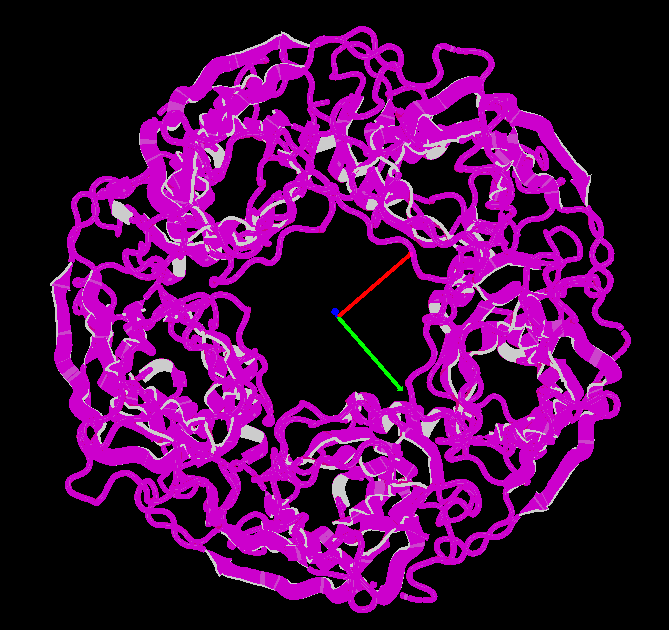

In [ ]:
# There are several functions about rotate, under biotite.structure
# rotate_centered(atom, angles): rotation about x, y, z by give angles. 

# First, let's copy the aligned and centered complex structure
aligned = one_complex_center_align_x_y_z.copy()
random_algined = struc.rotate_centered(aligned, (0,0,30)) # Here I rotate aroud z for 30 degrees
pdb.set_structure(random_algined)
pdb.write("random_algined.pdb")

# A more productive to do it is set up a grid (using itertools to generate a bunch of parameters to rotate and do some kinds of design)

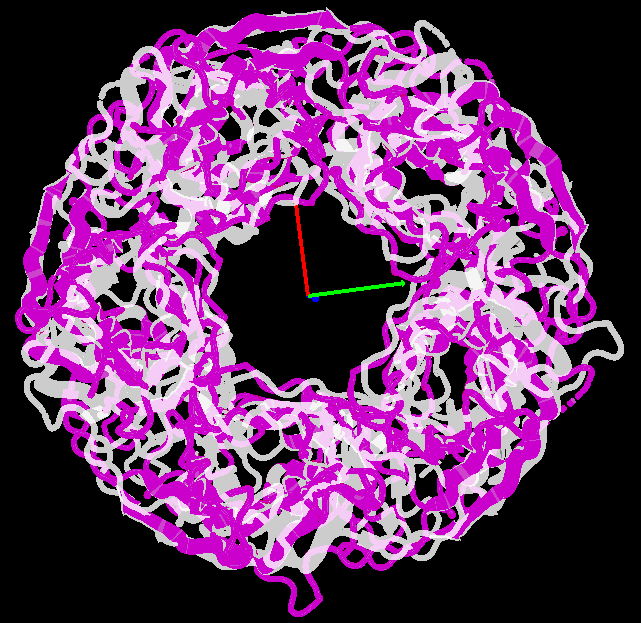

In [ ]:
# I think it is a general good practice to first center the protein and align it to axes before doing any rotation.
# But if you dont want to do that, you can still rotate in a 'guided' way by using rotate_about_axis
# rotate_about_axis(atoms, axis, angle, support=None)

aligned = one_complex_center_align_x_y_z.copy()
random_algined = struc.rotate_about_axis(aligned, axis=[0,0,1], angle=30) # this will generate the exact same result as above

In [ ]:
# another function is align_vectors(atoms, origin_direction, target_direction, origin_position=None, target_position=None)[source]
# I think this function is very useful to create symmetry because you could copy structure, 
# then align certain vector to another vector to create symmetry
# This can be done by first measuring the radius of gyration using struc.radius_of_gyration(atoms, center=None)
# Then move the structure along certain axis by the radius of gyration, then align the vector to another vector
# Here is an example about creating a C5 complex (using C5 complex :)


# Get the radius of gyration of the complex
aligned_complex = one_complex_center_align_x_y_z.copy()
Rg = struc.gyration_radius(aligned_complex)
distance = 2.2 * Rg
print("Rg:", Rg, " distance:", distance)


# The actual vector is x-axis, but I set it to z-axis here
origin_dir = np.array([0,0,1])

# equally divide angle to 5 pieces
angles = np.linspace(0, 2*np.pi, 5, endpoint=False)
# the angle of target vector
target_dirs = [np.array([np.cos(a), np.sin(a), 0.0]) for a in angles]
# the distance of target vector
target_positions = [distance * d for d in target_dirs]


def rotate_complex(complex5, origin_dir, target_dir, target_pos):
    return struc.align_vectors(
        atoms=complex5,
        origin_direction=origin_dir,
        target_direction=target_dir,
        origin_position=np.array([0,0,0]),
        target_position=target_pos
    )

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# enough for 25 chains
chain_ids_25 = list(alphabet[:25])

subunits = []
chain_counter = 0

for td, tp in zip(target_dirs, target_positions):
    # apply symmetry to whole 5-chain complex
    new_complex = rotate_complex(aligned_complex, origin_dir, td, tp)

    # assign 5 unique chain IDs for this rotated complex
    unique_ids = chain_ids_25[chain_counter : chain_counter+5]
    chain_counter += 5

    # remap chain IDs
    for old_id, new_id in zip(np.unique(new_complex.chain_id), unique_ids):
        new_complex.chain_id[new_complex.chain_id == old_id] = new_id

    subunits.append(new_complex)

# Need to combine all the chains
C5_25chains = struc.concatenate(subunits)

pdb = PDBFile()
pdb.set_structure(C5_25chains)
pdb.write("C5_25chains.pdb")



Rg: 29.925646989797023  distance: 65.83642337755346


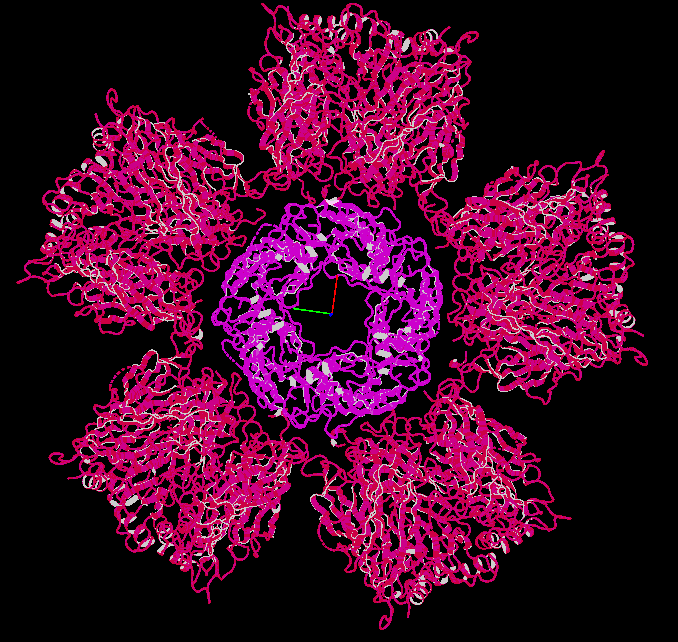

pymolrc used in this jupyter notebook

In [9]:

from pymol import cmd, util
from pymol.cgo import CYLINDER, CONE

# ---------- Axes ----------
def draw_axes(length=12.0, radius=0.25):
    """Draw RGB coordinate axes at origin (X=red, Y=green, Z=blue)"""
    obj = [
        # X (red)
        CYLINDER, 0,0,0,  length,0,0,  radius, 1,0,0, 1,0,0,
        CONE,     length,0,0,  length+2*radius,0,0,  radius*2,0.0,  1,0,0, 1,0,0, 1.0,1.0,
        # Y (green)
        CYLINDER, 0,0,0,  0,length,0,  radius, 0,1,0, 0,1,0,
        CONE,     0,length,0,  0,length+2*radius,0,  radius*2,0.0,  0,1,0, 0,1,0, 1.0,1.0,
        # Z (blue)
        CYLINDER, 0,0,0,  0,0,length,  radius, 0,0,1, 0,0,1,
        CONE,     0,0,length,  0,0,length+2*radius,  radius*2,0.0,  0,0,1, 0,0,1, 1.0,1.0
    ]
    cmd.load_cgo(obj, "axes")
cmd.extend("draw_axes", draw_axes)

# ---------- Global aesthetics ----------
def _pymol_startup():
    # Background & lighting
    cmd.bg_color("white")
    cmd.set("ray_opaque_background", 0)
    cmd.set("ambient", 0.65)
    cmd.set("direct", 0.7)
    cmd.set("spec_reflect", 0.25)
    cmd.set("spec_power", 100)
    cmd.set("shininess", 20)
    cmd.set("light_count", 8)
    cmd.set("depth_cue", 0)

    # Anti-aliasing & quality
    cmd.set("antialias", 4)
    cmd.set("ray_trace_mode", 3)
    cmd.set("ray_trace_gain", 0.1)
    cmd.set("ray_shadow", 0)
    cmd.set("transparency_mode", 2)
    cmd.set("cartoon_transparency", 0.2)

    # Cartoon / ribbon style
    cmd.set("cartoon_sampling", 14)
    cmd.set("cartoon_oval_length", 1.0)
    cmd.set("cartoon_oval_width", 0.25)
    cmd.set("cartoon_rect_width", 0.3)
    cmd.set("cartoon_loop_radius", 0.4)
    cmd.set("cartoon_flat_sheets", 0)
    cmd.set("cartoon_highlight_color", "grey90")
    cmd.set("cartoon_side_chain_helper", 0)
    cmd.unset("cartoon_smooth_loops")

    # Representation defaults
    cmd.set("stick_radius", 0.18)
    cmd.set("sphere_scale", 0.3)
    cmd.set("line_width", 2)
    cmd.set("dash_gap", 0.2)
    cmd.set("dash_radius", 0.05)
    cmd.set("transparency", 0.25)

    # Labels & view
    cmd.set("label_size", 14)
    cmd.set("label_font_id", 7)
    #cmd.set("orthoscopic", 1)

    # Start clean & nice
    cmd.hide("everything")
    cmd.show("cartoon")
    util.cbc()  # initial object (if any)

    # Draw axes
    draw_axes(12.0, 0.25)

    print("PyMOL aesthetic setup loaded — auto-color enabled.")

_pymol_startup()


ModuleNotFoundError: No module named 'pymol'